<a href="https://colab.research.google.com/github/Quantum-SMC/Private-Computation-of-Boolean-Functions-Using-Single-Qubits/blob/main/equivalance_quantum_smc_protocol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing requirements

In [1]:
!pip install qiskit==0.43.2
!pip install qiskit[visualization]==0.43.2
!pip install qiskit-aer==0.12.1

In [13]:
from math import sqrt, pi, exp
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error, amplitude_damping_error, phase_damping_error)

Implementation of a new Secure Multipary Computation (SMC) protocol to compute symmetric Boolean. In the following the 2-bit Equivalence function of Alice's and Bob's private input is computed.

In [14]:
# Private inputs of Alice and Bob
a1 = 1
a2 = 1
b1 = 1
b2 = 1
r = [1, 1, 1, 1]  # random bits that are shared between Alice and Bob.

In [15]:
# Polynomials to compute Equivalence fuction
P = [
    1^a1^a2^(a1&a2),
    1,
    1^a2,
    1^a1
]
Q = [
    1,
    b1&b2,
    b1,
    b2
]

First we run the protocol in a ideal setting where all quantum noise are ignored.

In [16]:
# constants
final_outcome = []
counts_list = []
colors = ['r', 'g', 'b', 'y']

# New SMC protocol to compute Boolean functions of degree 2
for i in range(0, 4):

    # Create a quantum circuit
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)

    # Alice rotates the qubit based on inputs r and a
    if r[i] == 1:
        qc.ry(pi, q[0])

    if P[i] == 1:
        qc.ry(pi/2, q[0])


    # Bob rotates the qubit based on inputs r and b
    if r[i] == 1:
        qc.ry(pi, q[0])

    if Q[i] == 1:
        qc.ry(pi/2, q[0])

    # Charlie rotates the qubit based on input XOR(a,b)
    if P[i] ^ Q[i] == 1:
        qc.ry(-pi/2, q[0])

    # Charlie measures the qubit in computational basis
    qc.measure(q[0], c[0])

    #visualization
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=100)
    result = job.result().get_counts()
    print(result)
    counts_list.append(result)
    #plot_histogram(result).savefig(f'histogram_iteration_{i}.png')

    # Extract the outcome from classical register
    c_values = [int(bit) for bit in list(result.keys())[0]]
    print("The measurement outcomes in round", i, "is: ", c_values[0])
    final_outcome.append(c_values[0])

print("counts_list", counts_list)
print("The final outcomes is: ", final_outcome[0] ^ final_outcome[1] ^ final_outcome[2] ^ final_outcome[3])

{'0': 100}
The measurement outcomes in round 0 is:  0
{'1': 100}
The measurement outcomes in round 1 is:  1
{'0': 100}
The measurement outcomes in round 2 is:  0
{'0': 100}
The measurement outcomes in round 3 is:  0
counts_list [{'0': 100}, {'1': 100}, {'0': 100}, {'0': 100}]
The final outcomes is:  1


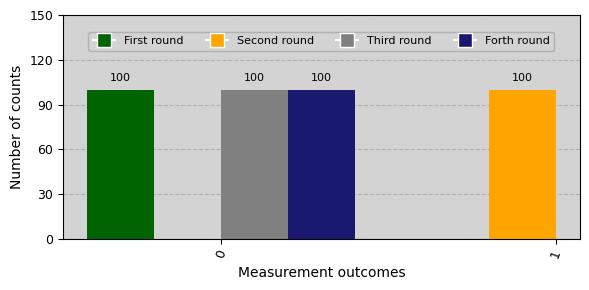

In [17]:
# Visualization of all rounds in a single diagram

# Create a new matplotlib figure and Axes object
fig, ax = plt.subplots(figsize=(6, 3))


legends = ['First round', 'Second round', 'Third round', 'Forth round']
colors=['darkgreen', 'orange', 'gray', 'midnightblue']
plot_histogram(counts_list, figsize=(10, 4), color=colors, bar_labels=False, ax=ax)

plt.xlabel("Measurement outcomes", fontsize=10)
plt.ylabel("Number of counts", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Customizing the legend
legend_labels = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10) for color in colors]
legend = plt.legend(legend_labels, legends, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(legends) , fontsize=8)
# Increase the y-axis limit
ax.set_ylim(0, 150)  # Set the desired limit here

# Set the background color
ax.set_facecolor('#D3D3D3')

# Set the background color of the legend
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('darkgray')

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(height, (rect.get_x() + rect.get_width() / 2, height),
                ha='center', va='bottom', fontsize=8,
                xytext=(0, 5), textcoords='offset points')

# Adjust the positioning of the plot within the figure
plt.tight_layout()
plt.savefig('histogram.png')



Now, we execute the protocol considering different quantum noise.

In [18]:
# New SMC protocol to compute binary Boolean functions

# constants
final_outcome = []
counts_list = []
colors = ['r', 'g', 'b', 'y']

# Error probabilities
p_bit_flip = 0.05
p_phase_flip = 0.05
p_amplitude_damping = 0.05
p_phase_damping = 0.05
p_depolarization = 0.05


for i in range(0, 4):

    # Create a quantum circuit
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)

    # Alice rotates the qubit based on inputs r and a
    if r[i] == 1:
        qc.ry(pi, q[0])

    if P[i] == 1:
        qc.ry(pi/2, q[0])


    # Bob rotates the qubit based on inputs r and b
    if r[i] == 1:
        qc.ry(pi, q[0])

    if Q[i] == 1:
        qc.ry(pi/2, q[0])

    # Charlie rotates the qubit based on input XOR(a,b)
    if P[i] ^ Q[i] == 1:
        qc.ry(-pi/2, q[0])

    # Charlie measures the qubit in computational basis
    qc.measure(q[0], c[0])


    # QuantumError objects -> gate error
    error_bit_flip = pauli_error([('X', p_bit_flip), ('I', 1 - p_bit_flip)])
    error_phase_flip = pauli_error([('Z', p_phase_flip), ('I', 1 - p_phase_flip)])
    error_amplitude_damping = amplitude_damping_error(p_amplitude_damping)
    error_phase_damping = phase_damping_error(p_phase_damping)
    error_depolarization = depolarizing_error(p_depolarization, 1)

    ################## Add errors to noise model ##################
    # Create an empty noise model
    noise_model = NoiseModel()

    # Compose errors for gates
    gate_errors = error_bit_flip.compose(error_phase_flip).compose(error_amplitude_damping).compose(error_phase_damping).compose(error_depolarization)
    noise_model.add_all_qubit_quantum_error(gate_errors, ["ry"])

    # Compose errors for measurements
    measurement_errors = error_bit_flip.compose(error_amplitude_damping)
    noise_model.add_all_qubit_quantum_error(measurement_errors, ["measure"])


    ################## Executing the noisy simulation ##################
    # Create noisy simulator backend
    sim_noise = AerSimulator(noise_model=noise_model)

    # Transpile circuit for noisy basis gates
    qc_tnoise = transpile(qc, sim_noise)

    # Run the circuit with noise model and get counts
    result = sim_noise.run(qc_tnoise, shots=1000).result()
    counts = result.get_counts()

    # Plot noisy output
    # plot_histogram(counts)

    # Print and store the counts
    print(counts)
    counts_list.append(counts)

    # Extract the outcome from counts
    max_outcome = max(counts, key=counts.get)
    print("The measurement outcome in round", i, "is:", max_outcome)
    final_outcome.append(int(max_outcome))

print("counts_lists", counts_list)

# Compute the final XOR outcome
final_xor = final_outcome[0] ^ final_outcome[1] ^ final_outcome[2] ^ final_outcome[3]
print("The final XOR outcome is:", final_xor)


{'1': 43, '0': 957}
The measurement outcome in round 0 is: 0
{'0': 201, '1': 799}
The measurement outcome in round 1 is: 1
{'1': 43, '0': 957}
The measurement outcome in round 2 is: 0
{'1': 48, '0': 952}
The measurement outcome in round 3 is: 0
counts_lists [{'1': 43, '0': 957}, {'0': 201, '1': 799}, {'1': 43, '0': 957}, {'1': 48, '0': 952}]
The final XOR outcome is: 1


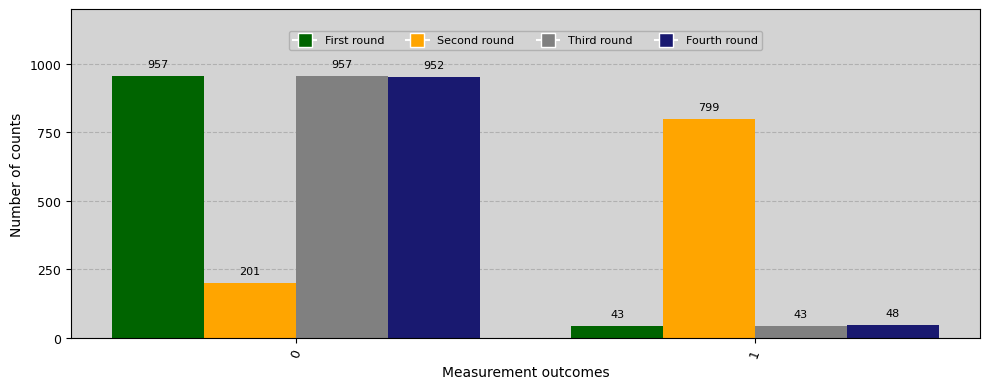

In [19]:
# Visualization of all rounds in a single diagram
# Create a new matplotlib figure and Axes object
fig, ax = plt.subplots(figsize=(10, 4))

# Legends and colors for each round
legends = ['First round', 'Second round', 'Third round', 'Fourth round']
colors = ['darkgreen', 'orange', 'gray', 'midnightblue']

# Plot histogram for all counts in a single diagram
plot_histogram(counts_list, figsize=(10, 4), color=colors, bar_labels=False, ax=ax)

# Customize plot labels
plt.xlabel("Measurement outcomes", fontsize=10)
plt.ylabel("Number of counts", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Customizing the legend
legend_labels = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10) for color in colors]
legend = plt.legend(legend_labels, legends, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(legends), fontsize=8)

# Increase the y-axis limit
ax.set_ylim(0, 1200)  # Set the desired limit here

# Set the background color
ax.set_facecolor('#D3D3D3')

# Set the background color of the legend
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('darkgray')

# Annotate the bars with the height value
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(height, (rect.get_x() + rect.get_width() / 2, height),
                ha='center', va='bottom', fontsize=8,
                xytext=(0, 5), textcoords='offset points')

# Adjust the positioning of the plot within the figure
plt.tight_layout()

# Save the figure
plt.savefig('histogram.png')

This part is only to draw the circuit. This version of the qiskit can not draw the circuit when looping is used.


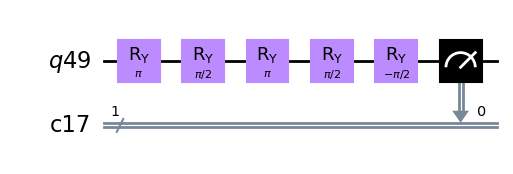

In [20]:
# Polynomials to compute Equivalence fuction
P = [
    1,
    1,
    1,
    1
]
Q = [
    1,
    1,
    1,
    1
]
r = [1, 1, 1, 1]
# Create a quantum circuit
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Alice rotates the qubit based on inputs r and a
if r[0] == 1:
  qc.ry(pi, q[0])

if P[0] == 1:
  qc.ry(pi/2, q[0])


# Bob rotates the qubit based on inputs r and b
if r[0] == 1:
  qc.ry(pi, q[0])

if Q[0] == 1:
  qc.ry(pi/2, q[0])

# Charlie rotates the qubit based on input XOR(a,b)
if 1 == 1:
  qc.ry(-pi/2, q[0])

# Charlie measures the qubit in computational basis
qc.measure(q[0], c[0])
qc.draw(output='mpl')